# Basic usage of SLAT

> (Estimated time: ~0.5 min)

In this vignette, we show how to use `SLAT` to align spatial datasets, using Stereo-seq data ([Chen. et al](https://www.sciencedirect.com/science/article/pii/S0092867422003993?via%3Dihub)) as an example. For demonstration purpose, we only subsample 6,000 cells from every dataset.

You need following files as input:

* Chen-Stereo_seq-E15.5-s1.h5ad: down sampled Stereo-seq dataset 1, download from [here](https://drive.google.com/uc?export=download&id=1AGxVhgrKF1zD1MNLrC0x032X5uF5blml)
* Chen-Stereo_seq-E15.5-s2.h5ad: down sampled Stereo-seq dataset 2, download from [here](https://drive.google.com/uc?export=download&id=1GzTYTS232TPPzlnj9lGrc_CMkhuVM5h4)

In [ ]:
# uncomment this if you want to use interactive plot (only works in Jupyter not works in VScode)
# %matplotlib widget

import scanpy as sc
import numpy as np
import pandas as pd

import scSLAT
from scSLAT.model import Cal_Spatial_Net, load_anndatas, run_SLAT, spatial_match
from scSLAT.viz import match_3D_multi, hist, Sankey

In [2]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=150, frameon=True, vector_friendly=True, fontsize=14)

## Load datasets
First, we need to prepare the single cell spatial data into `AnnData` objects. `AnnData` is the standard data class we use in `scSLAT`. See their [documentation](https://anndata.readthedocs.io/en/latest/index.html) for more details if you are unfamiliar, including how to construct `AnnData` objects from scratch, and how to read data in other formats (csv, mtx, loom, etc.) into `AnnData` objects.

Here we just load existing `h5ad` files, which is the native file format for `AnnData`. The `h5ad` files used in this tutorial can be downloaded from here:

* [https://drive.google.com/uc?export=download&id=1AGxVhgrKF1zD1MNLrC0x032X5uF5blml](https://drive.google.com/uc?export=download&id=1AGxVhgrKF1zD1MNLrC0x032X5uF5blml)
* [https://drive.google.com/uc?export=download&id=1GzTYTS232TPPzlnj9lGrc_CMkhuVM5h4](https://drive.google.com/uc?export=download&id=1GzTYTS232TPPzlnj9lGrc_CMkhuVM5h4)

In [4]:
adata1 = sc.read_h5ad('./Chen-Stereo_seq-E15.5-s1.h5ad')
adata2 = sc.read_h5ad('./Chen-Stereo_seq-E15.5-s2.h5ad')

To begin with, we suppose `adata.X` stores the raw UMI counts of scRNA-seq expression matrix, and `adata.obsm['spatial']` stores the spatail coordinates of every cell

In [5]:
adata1

AnnData object with n_obs × n_vars = 6000 × 28798
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - AI987944', 'Brain_shapes', 'Face_shapes', 'Heart_shapes', 'Lung_shapes', 'Liver_shapes', 'Shapes_shapes', 'Belly_shapes', 'Back_shapes', 'region'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'region_colors'
    obsm: 'spatial', 'spatial_back'
    varm: 'PCs'

Then we visualize two datasets colored by cell type:

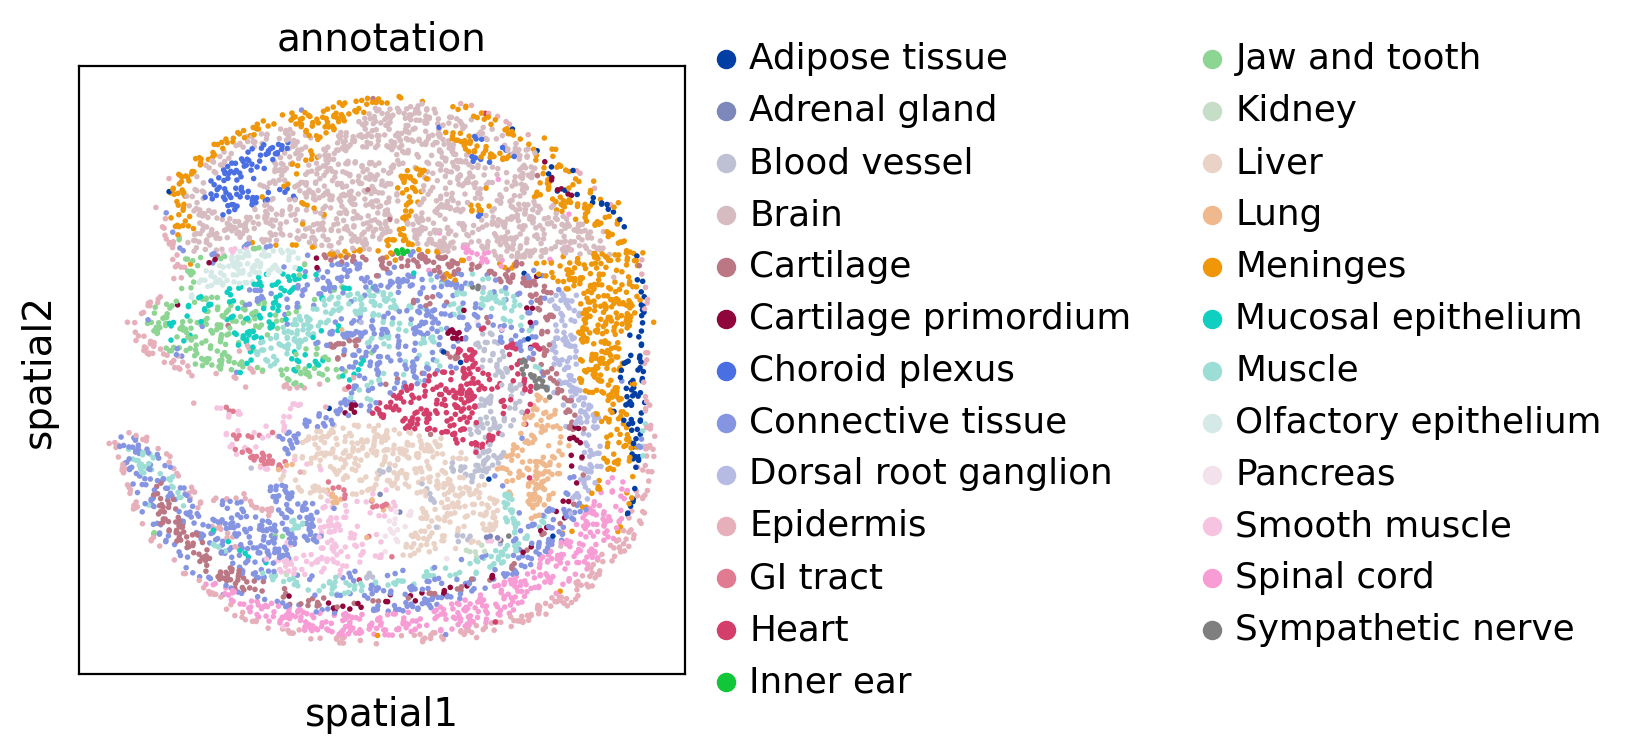

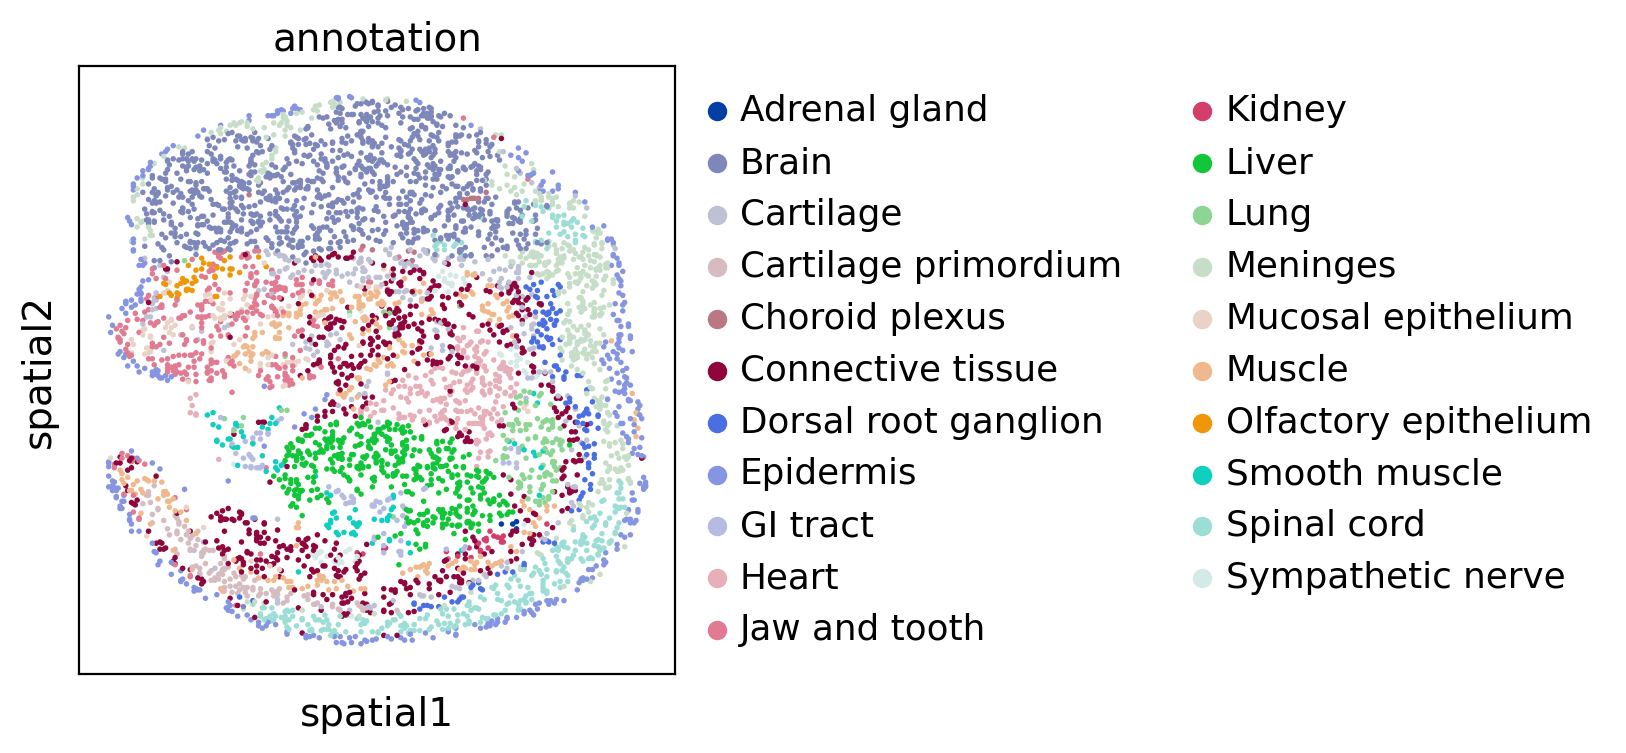

In [6]:
sc.pl.spatial(adata1, color="annotation", spot_size=10)
sc.pl.spatial(adata2, color="annotation", spot_size=10)

## Run SLAT
SLAT need to build neighbor graphs based on cell-cell distance of every dataset respectively.

In [7]:
Cal_Spatial_Net(adata1, k_cutoff=10, model='KNN')
Cal_Spatial_Net(adata2, k_cutoff=10, model='KNN')

Calculating spatial neighbor graph ...
The graph contains 68008 edges, 6000 cells.
11.334666666666667 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 56646 edges, 5000 cells.
11.3292 neighbors per cell on average.


Then, SLAT extract cell gene expression features by a SVD-based matrix factorization algorithm (we named it 'DPCA'), and extract edges of graphs we built in previous step.
> NOTE: SLAT support three built-in embedding algorithms (`DPCA`, `Harmony`, and `PCA`) currently. But you can use any embedding method manually.

In [8]:
edges, features = load_anndatas([adata1, adata2], feature='DPCA')

Use DPCA feature to format graph


/home/xiacr/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/xiacr/.local/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/xiacr/.local/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/xiacr/.local/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Warning! Dual PCA is using GPU, which may lead to OUT OF GPU MEMORY in big dataset!


Then we train SLAT model, it's very fast and finish in 10s.
> Warning: SLAT default hyperparameter can handle most situation. You should not change them unless you know details very well.

In [9]:
embd0, embd1, time = run_SLAT(features, edges)

Choose GPU:1 as device
Running
Training model time: 3.57


## Aligning and visualization 
Then we align the datasets base on SLAT embedding

In [10]:
best, index, distance = spatial_match([embd0, embd1], adatas=[adata1,adata2], reorder=False)

In [11]:
adata1_df = pd.DataFrame({'index': range(embd0.shape[0]),
                        'x': adata1.obsm['spatial'][:,0],
                        'y': adata1.obsm['spatial'][:,1],
                        'celltype': adata1.obs['annotation']})
adata2_df = pd.DataFrame({'index': range(embd1.shape[0]),
                        'x': adata2.obsm['spatial'][:,0],
                        'y': adata2.obsm['spatial'][:,1],
                        'celltype': adata2.obs['annotation']})

matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]

Then we visualize the cell to cell matching, colored by cell type. By default, Blue line means correct match of cell type, red line is the opposite.

dataset1: 25 cell types; dataset2: 21 cell types; 
                    Total :25 celltypes; Overlap: 21 cell types 
                    Not overlap :[['Pancreas', 'Inner ear', 'Adipose tissue', 'Blood vessel']]
Subsampled 300 pairs from 5000


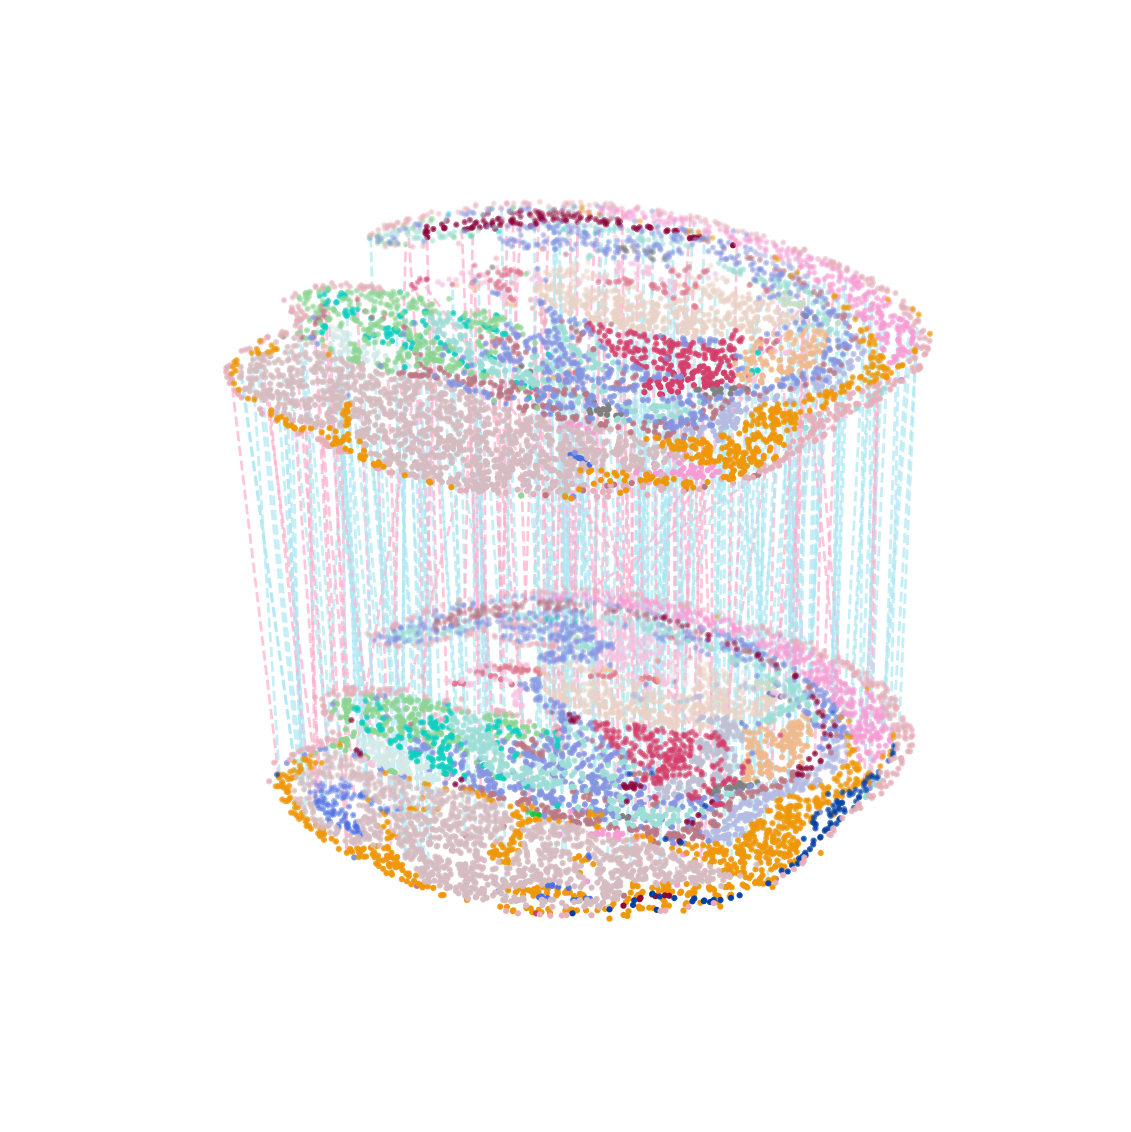

In [12]:
multi_align = match_3D_multi(adata1_df, adata2_df, matching,meta='celltype',
                            scale_coordinate=True, subsample_size=300)
multi_align.draw_3D(size=[7, 8], line_width=1, point_size=[1.5,1.5], hide_axis=True)

## Similarity score
**Similarity score** means the confident of `SLAT` alignment. Regions with low similarity scores may 1) have biological difference; 2)cause by technology variance.
We can also plot the distribution of the similarity score of aligned cells.

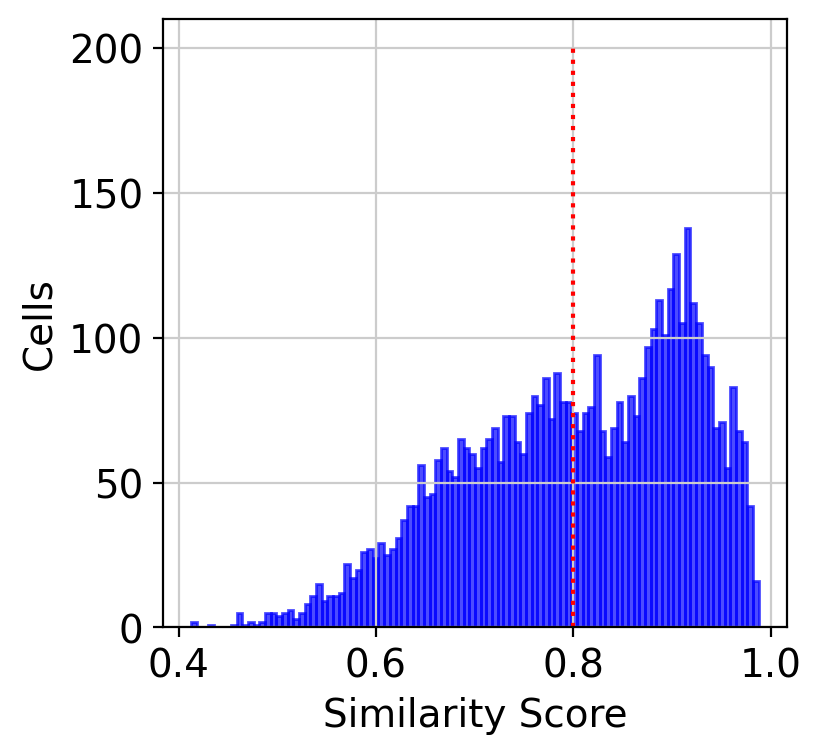

In [13]:
%matplotlib inline
hist(best_match, cut=0.8)

We also can visualize the similarity score spatially.

In [14]:
adata2.obs['low_quality_index'] = best_match 
adata2.obs['low_quality_index'] = adata2.obs['low_quality_index'].astype(float)

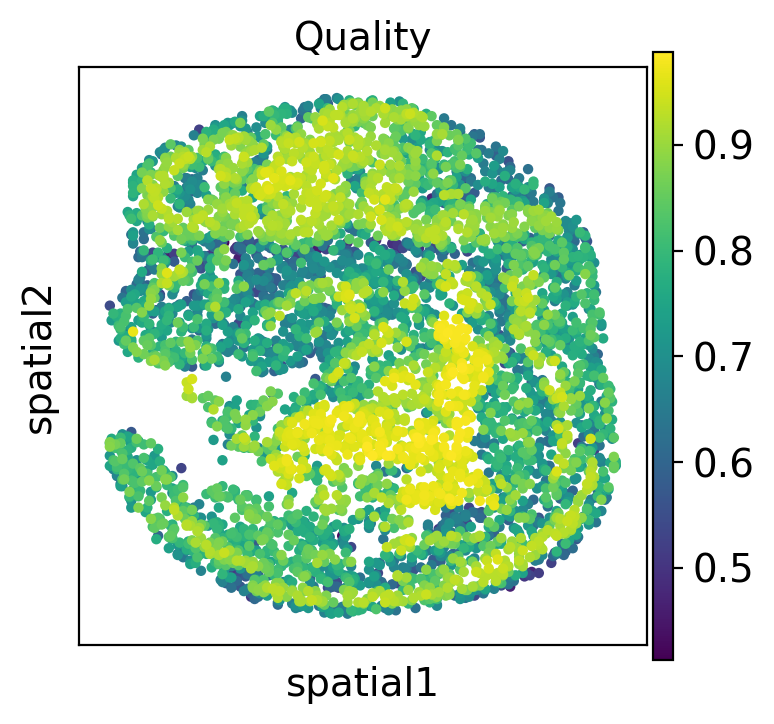

In [15]:
sc.pl.spatial(adata2, color='low_quality_index', spot_size=20, title='Quality')

## Cell type level analysis 
We can check the cell type level corresponding via Sankey diagram.

In [16]:
adata2_df['target_celltype'] = adata1_df.iloc[matching[1,:],:]['celltype'].to_list()
matching_table = adata2_df.groupby(['celltype','target_celltype']).size().unstack(fill_value=0)

In [17]:
Sankey(matching_table, prefix=['E15.5_E1S1','E15.5_E1S2'])